In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, recall_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sqlite3
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

In [2]:
conn = sqlite3.connect(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\data.db')
cursor = conn.cursor()

In [3]:
query = ('''
WITH mean_deposite as (
    select 
         client_id,
         AVG(balance) as mean_balance,
         MAX(balance) as max_balance,
         MIN(balance) as min_balance,
         MAX(balance)-MIN(balance) as dif_balance,
         currency
    from balances
    group by 1
)
Select * 
from inv_campaign_eval
left join client
on inv_campaign_eval.client_id = client.client_id
left join client_products
on inv_campaign_eval.client_id = client_products.client_id
left join mean_deposite
on inv_campaign_eval.client_id = mean_deposite.client_id''')
df = pd.read_sql_query(query, conn)

df.head()

,client_id,poutcome,client_id,age,job,marital,education,gender,client_id,has_deposits,loan,has_insurance,has_mortgage,client_id,mean_balance,max_balance,min_balance,dif_balance,currency
0,249789938,success,249789938,38.0,services,married,secondary,M,249789938,yes,no,n,no,249789938,2669.532734,2775.615374,2515.500059,260.115315,CZK
1,1504633819,failure,1504633819,38.0,management,married,tertiary,M,1504633819,no,yes,n,yes,1504633819,5440.862334,5529.866975,5344.385346,185.481629,CZK
2,1952195738,success,1952195738,34.0,services,married,secondary,M,1952195738,yes,yes,n,no,1952195738,2922.958852,3016.314818,2852.824056,163.490762,CZK
3,989726384,success,989726384,62.0,retired,married,secondary,F,989726384,yes,no,n,no,989726384,3124.614843,3212.174671,3011.445910,200.728761,CZK
4,1971878545,failure,1971878545,36.0,management,single,tertiary,M,1971878545,yes,no,n,no,1971878545,474.083033,571.028715,362.809777,208.218939,CZK


In [9]:
faill_df = df[df['poutcome'] == 'failure']
faill_df.mean_balance.mean(), faill_df.mean_balance.median(), faill_df.count()

(1544.9374636853986,
 657.1264238104209,
 client_id        1228
 poutcome         1228
 age              1201
 job              1186
 marital          1228
 education        1228
 gender           1228
 has_deposits     1228
 loan             1228
 has_insurance    1228
 has_mortgage     1228
 mean_balance     1228
 max_balance      1228
 min_balance      1228
 dif_balance      1228
 currency         1228
 dtype: int64)

In [10]:
suc_df = df[df['poutcome'] == 'success']

suc_df.mean_balance.mean(), suc_df.mean_balance.median(), suc_df.count()

(1980.798580279579,
 868.5785057907923,
 client_id        1071
 poutcome         1071
 age              1048
 job              1030
 marital          1071
 education        1071
 gender           1071
 has_deposits     1071
 loan             1071
 has_insurance    1071
 has_mortgage     1071
 mean_balance     1071
 max_balance      1071
 min_balance      1071
 dif_balance      1071
 currency         1071
 dtype: int64)

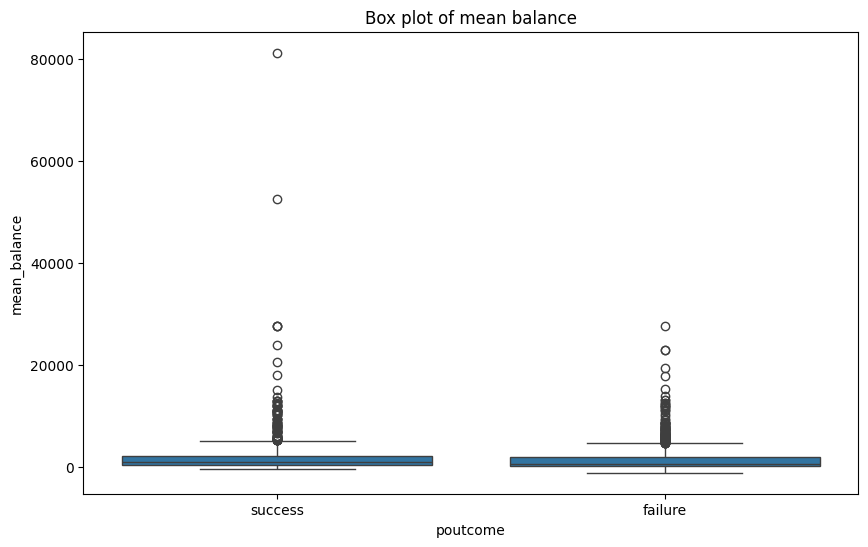

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='poutcome', y='mean_balance')
plt.title('Box plot of mean balance')
plt.xticks(ticks=[0,1], labels=['success', 'failure'])  # renaming species for better understanding
plt.show()

In [4]:
df = df.T.drop_duplicates().T
df.mean_balance = pd.to_numeric(df.mean_balance)
df.max_balance = pd.to_numeric(df.max_balance)
df.min_balance = pd.to_numeric(df.min_balance)


In [5]:
rate = {'CZK': 1, 'USD': 23, 'EUR': 25}

df.mean_balance = df.apply(lambda row: row['mean_balance'] * rate[row['currency']], axis=1)
df.max_balance = df.apply(lambda row: row['max_balance'] * rate[row['currency']], axis=1)
df.min_balance = df.apply(lambda row: row['min_balance'] * rate[row['currency']], axis=1)
df1 = df.drop(columns='client_id')


In [14]:
y = df1.poutcome
X = df1.drop(columns = 'poutcome')
enc = LabelEncoder()
y=enc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
y_train

array([1, 1, 0, ..., 0, 1, 0])

In [13]:
class InteractionScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Assuming the first two columns are the ones we're interested in
        self.max_interaction = X[:, :2].max()
        return self

    def transform(self, X):
        # Create an interaction score: a simple product of the first two columns
        interaction_score = (X[:, 0] * X[:, 1]) / self.max_interaction
        return np.hstack((X, interaction_score[:, None]))



In [15]:
num_features = ['age', 'mean_balance', 'max_balance', 'min_balance', 'dif_balance']
cat_features = ['job', 'currency']
labeled_features = ['marital', 'education', 'gender', 'has_deposits', 'loan', 'has_insurance', 'has_mortgage']


# Create transformers for the numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

labeled_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='no')),
    ('label', OrdinalEncoder())])


# Create a column transformer to apply the transformations to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('label', labeled_transformer, labeled_features)
            ])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('interaction', InteractionScoreTransformer()),
    ('classifier', GradientBoostingClassifier(criterion = 'squared_error', learning_rate=0.1, loss='log_loss', n_estimators=50))])

In [16]:
# Fit the preprocessor
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'mean_balance',
                                                   'max_balance', 'min_balance',
                                                   'dif_balance']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_...
                                                  ['job', 'currency']),
                                                 ('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='no',
                                                                                 strategy='constant')),
                                                                  ('label',
                                                                   OrdinalEncoder())]),
                                                  ['marital', 'education',
                                                   'gender', 'has_deposits',
                                                   'loan', 'has_insurance',
                                                   'has_mortgage'])])),
                ('interaction', InteractionScoreTransformer()),
                ('classifier',
                 GradientBoostingClassifier(criterion='squared_error',
                                            n_estimators=50))])

In [17]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100), "Recall: {:.2f}%".format(recall * 100))


Accuracy: 70.00% Recall: 73.06%


In [18]:
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [51]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'loss': ('log_loss', 'exponential'),
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 150, 200],
    'criterion': ('friedman_mse', 'squared_error')
}
dt = GradientBoostingClassifier()
gs = GridSearchCV(dt, parameters, scoring='recall')
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.130551,0.007661,0.002088,0.002105,friedman_mse,0.01,log_loss,50,"{'criterion': 'friedman_mse', 'learning_rate':...",0.713450,0.719298,0.694118,0.664706,0.723529,0.703020,0.021641,29
1,0.267143,0.011524,0.000862,0.001062,friedman_mse,0.01,log_loss,100,"{'criterion': 'friedman_mse', 'learning_rate':...",0.713450,0.777778,0.694118,0.717647,0.735294,0.727657,0.028275,19
2,0.388715,0.005931,0.000737,0.000908,friedman_mse,0.01,log_loss,150,"{'criterion': 'friedman_mse', 'learning_rate':...",0.783626,0.777778,0.694118,0.717647,0.735294,0.741692,0.034476,13
3,0.509282,0.016070,0.002912,0.003986,friedman_mse,0.01,log_loss,200,"{'criterion': 'friedman_mse', 'learning_rate':...",0.783626,0.777778,0.764706,0.741176,0.735294,0.760516,0.019286,3
4,0.127401,0.009436,0.000000,0.000000,friedman_mse,0.01,exponential,50,"{'criterion': 'friedman_mse', 'learning_rate':...",0.713450,0.719298,0.694118,0.664706,0.723529,0.703020,0.021641,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.451480,0.006684,0.003124,0.006248,squared_error,1,log_loss,200,"{'criterion': 'squared_error', 'learning_rate'...",0.596491,0.625731,0.664706,0.582353,0.588235,0.611503,0.030494,62
60,0.126327,0.019478,0.003654,0.006058,squared_error,1,exponential,50,"{'criterion': 'squared_error', 'learning_rate'...",0.625731,0.684211,0.682353,0.594118,0.617647,0.640812,0.036204,45
61,0.310325,0.040386,0.002009,0.002197,squared_error,1,exponential,100,"{'criterion': 'squared_error', 'learning_rate'...",0.619883,0.678363,0.664706,0.588235,0.629412,0.636120,0.032259,55
62,0.403265,0.009355,0.002773,0.002905,squared_error,1,exponential,150,"{'criterion': 'squared_error', 'learning_rate'...",0.625731,0.701754,0.635294,0.594118,0.641176,0.639615,0.035058,49


In [52]:
results.loc[results["rank_test_score"] == 1]
#DecisionTreeClassifier(criterion='entropy', max_depth = 6, min_samples_split = 3)
#AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = 0.5, n_estimators = 50)
#GradientBoostingClassifier(criterion = 'friedman_mse', learning_rate=0.01, loss='log_loss', n_estimators=200)  for only main features
#GradientBoostingClassifier(criterion = 'squared_error', learning_rate=0.1, loss='log_loss', n_estimators=50)  for all features 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.126753,0.006583,0.000368,0.000737,squared_error,0.1,log_loss,50,"{'criterion': 'squared_error', 'learning_rate'...",0.77193,0.783626,0.782353,0.741176,0.741176,0.764052,0.019114,1


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7213 - loss: 0.5643
Test Loss: 0.5704582929611206, Test Accuracy: 0.7021738886833191


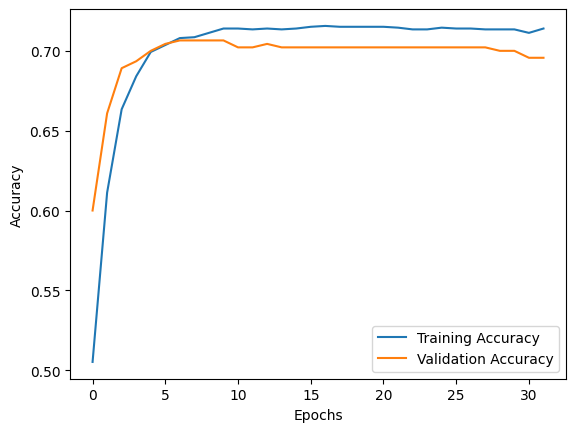

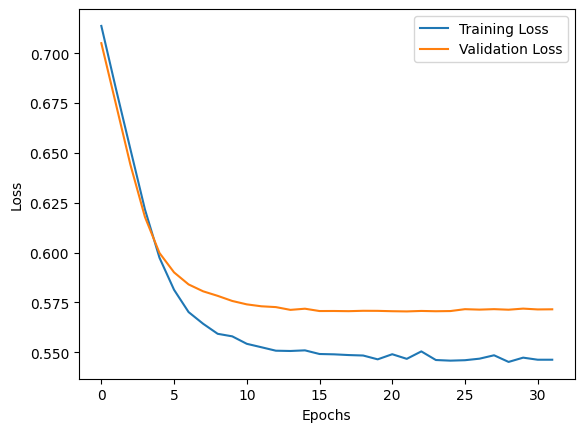

In [45]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training accuracy vs. test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss vs. validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

model = Sequential([
    Dense(64, activation='relu', input_shape=(26,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/100


c:\Users\spiri\anaconda3\envs\tf-gpu\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4996 - loss: 1.0464 - val_accuracy: 0.6522 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5736 - loss: 0.8500 - val_accuracy: 0.6717 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6011 - loss: 0.8141 - val_accuracy: 0.6870 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6327 - loss: 0.7657 - val_accuracy: 0.6913 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6495 - loss: 0.7404 - val_accuracy: 0.6935 - val_loss: 0.6671 - learning_rate: 0.0010
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6605 - loss: 0.7221 - val_accuracy: 0.6978 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 0.7242 - val_accuracy: 0.693